```python
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# -----------------------------
# 설정
# -----------------------------
img_height = 32       # 셀 이미지 높이
img_width = 128       # 셀 이미지 폭
num_channels = 1      # 흑백 이미지
max_text_length = 10  # 한 셀 최대 글자 길이
characters = "0123456789DST"  # 인식할 문자 집합
num_classes = len(characters) + 1  # CTC용 blank 문자 추가

# 문자 → 인덱스
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="", invert=True)

# -----------------------------
# CNN + BiLSTM + CTC 모델
# -----------------------------
def build_model():
    input_img = layers.Input(shape=(img_height, img_width, num_channels), name='image')

    # CNN feature extractor
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # CNN 출력 → 시퀀스 변환
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    
    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = models.Model(inputs=input_img, outputs=output)
    return model

# -----------------------------
# CTC Loss 계산용 레이어
# -----------------------------
class CTCLossLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')

        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# -----------------------------
# 모델 컴파일
# -----------------------------
base_model = build_model()
labels = layers.Input(name='label', shape=(max_text_length,), dtype='float32')

output = CTCLossLayer()(labels, base_model.output)
model = models.Model(inputs=[base_model.input, labels], outputs=output)

model.compile(optimizer='adam')
model.summary()

# -----------------------------
# 데이터 준비 예시
# -----------------------------
# X: (num_samples, img_height, img_width, 1)
# y: (num_samples, max_text_length) 정수 인덱스
# 실제 학습 시에는 셀 이미지를 crop해서 resize 후 char_to_num으로 변환

# X_dummy = np.random.rand(32, img_height, img_width, 1).astype(np.float32)
# y_dummy = np.random.randint(0, num_classes, size=(32, max_text_length))

# model.fit([X_dummy, y_dummy], y_dummy, epochs=10, batch_size=8)


```python
from pandas import CategoricalDtype, read_csv, DataFrame
import pandas as pd
from math import floor, log10
from pathlib import Path
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
import tensorflow as tf
from matplotlib.pyplot import figure, axis, imshow, show
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

_1 = 'DEFEAT', 'DRAW', 'VICTORY'
_2 = {'TEAM': 'uint8', 'ROLE': CategoricalDtype(('ALL', 'TANK', 'DAMAGE', 'SUPPORT', 'NONE')), 'E': 'uint8', 'A': 'uint8',
      'D': 'uint8', 'DMG': 'uint16', 'H': 'uint16', 'MIT': 'uint16'}
_3 = (('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2))
_4 = 1, 2
_5 = [_6 for _6 in _2 if _6 not in {'TEAM', 'ROLE'}]
_7 = pd.concat((pd.read_csv(f'ROLE/{_8}.csv', index_col=0, dtype=_2) for _8 in _1), keys=_1, names=('RESULT',))
_7.dropna(inplace=True)


def _9(_10):
    _11 = {_12: [] for _12 in _2}
    for _13 in _4:
        _14 = _10[_10['TEAM'] == _13]
        for _15, _16 in _3:
            for _17 in range(_16 - sum(_14['ROLE'] == _15)):
                _11['TEAM'].append(_13)
                _11['ROLE'].append(_15)
                for _18 in _5:
                    _11[_18].append(0)
    return DataFrame(_11).astype(_2)


_19 = pd.concat([_7, _7.groupby(level=(0, 1)).apply(_9)])
_19.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)
_20 = DataFrame()
_20['TEAM'] = _19['TEAM'] - 1
_20['ROLE'] = _19['ROLE'].cat.codes.astype('uint8')
for _21 in _5:
    for _22 in range(floor(log10(_19[_21].max())), -1, -1):
        _20[f'{_21}{_22}'] = (_19[_21] // 10 ** _22 % 10).astype('uint8')
_23 = tuple(_20.to_numpy().reshape(-1, 230).T)


def _24(_25, _26):
    _27 = decode_png(read_file(_25), 1)[230:930, 530:1370]
    _28 = resize(tf.concat(
        [_27[:, :40], _27[:, 390:420], _27[:, 450:480], _27[:, 500:530], _27[:, 570:640], _27[:, 670:740],
         _27[:, 770:]], 1), (300, 300)) / 255
    return _28, _26


_29 = sorted(map(str, Path().rglob('*.png')))
_30 = len(_23[0])
_31 = Dataset.from_tensor_slices((_29, _23)).map(_24, AUTOTUNE).shuffle(_30)
_32 = int(_30 * .9)
_33 = _31.take(_32).batch(32).prefetch(AUTOTUNE)
_34 = _31.skip(_32).batch(32).prefetch(AUTOTUNE)
for _35, _36 in _33.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(_35[0], 'gray')
    show()
    print(*(_37[0].numpy() for _37 in _36), sep='')
clear_session()
_38 = Input(_35.shape[1:])
_39 = Conv2D(32, (3, 3), activation='relu')(_38)
_40 = MaxPooling2D()(_39)
_41 = Conv2D(64, (3, 3), activation='relu')(_40)
_42 = MaxPooling2D()(_41)
_43 = Flatten()(_42)
_44 = _20.nunique()
_45 = Dense(128, 'relu')(_43)
_46 = tuple(Dense(_44[_47], 'softmax', name=f'{_47}_{_48}')(_45) for _48 in range(10) for _47 in _44.index)
_49 = Model(inputs=_38, outputs=_46)
_49.compile('SGD', 'sparse_categorical_crossentropy', metrics=['accuracy'] * len(_46))
_50 = _49.fit(_33, epochs=1000, callbacks=EarlyStopping(patience=10, restore_best_weights=True), validation_data=_34)

In [244]:
import pandas as pd
from pandas import CategoricalDtype, read_csv


# --- 변환 함수 정의 ---
def to_int(value):
    return int(value) if value else 0


def to_int_with_commas(value):
    return int(value.replace(',', '')) if value else 0


# 각 컬럼별 변환 규칙
converters = {
    'T': lambda v: int(v) if v else 1,
    'R': lambda v: v if v else 'A',
    'E': to_int,
    'A': to_int,
    'DE': to_int,
    'DA': to_int_with_commas,
    'H': to_int_with_commas,
    'M': to_int_with_commas,
}

# 각 컬럼별 dtype 지정
dtypes = {
    'T': CategoricalDtype(categories=(1, 2)),
    'R': CategoricalDtype(categories=('A', 'T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'DE': 'uint8',
    'DA': 'uint16',
    'H': 'uint16',
    'M': 'uint16',
}

# 읽을 파일 목록
file_keys = ('DE', 'DR', 'V')

# --- CSV 읽기 및 병합 ---
df = pd.concat(
    (read_csv(f'R/{key}.csv', index_col=0, converters=converters).astype(dtypes) for key in file_keys),
    keys=file_keys,
    names=('RE',)
)
df

T  R   E  A  DE    DA     H     M
RE I                                     
DE 1    1  T   0  0   8  2947  1425  4611
   1    1  D   1  0   3  1818     0   650
   1    1  D   2  0   7  4735   487   308
   1    1  S   1  0   3  2078  2748     0
   1    1  S   1  1   3   269  5848   189
...    .. ..  .. ..  ..   ...   ...   ...
V  467  2  T   7  2   4  6453     0  9665
   467  2  D  10  0   5  6272    62  1417
   467  2  D   6  1   7  5267    78    76
   467  2  S   5  1   6  4602  8211   716
   467  2  S   2  5   7  1979  7396   329

[9110 rows x 8 columns]

In [245]:
# --- Categorical → 코드값(uint8) 변환 ---
df['T'] = df['T'].cat.codes.astype('uint8', False)
df['R'] = df['R'].cat.codes.astype('uint8', False)
numeric = df.columns[2:]
numeric_max = df[numeric].max()
df[numeric] = (df[numeric] / numeric_max).astype('float32', False)
df

T  R         E         A        DE        DA         H         M
RE I                                                                    
DE 1    0  1  0.000000  0.000000  0.347826  0.098489  0.053938  0.134428
   1    0  2  0.017544  0.000000  0.130435  0.060758  0.000000  0.018950
   1    0  2  0.035088  0.000000  0.304348  0.158245  0.018434  0.008979
   1    0  3  0.017544  0.000000  0.130435  0.069447  0.104016  0.000000
   1    0  3  0.017544  0.016129  0.130435  0.008990  0.221356  0.005510
...    .. ..       ...       ...       ...       ...       ...       ...
V  467  1  1  0.122807  0.032258  0.173913  0.215661  0.000000  0.281770
   467  1  2  0.175439  0.000000  0.217391  0.209612  0.002347  0.041311
   467  1  2  0.105263  0.016129  0.304348  0.176024  0.002952  0.002216
   467  1  3  0.087719  0.016129  0.260870  0.153800  0.310799  0.020874
   467  1  3  0.035088  0.080645  0.304348  0.066139  0.279950  0.009592

[9110 rows x 8 columns]

In [246]:
# --- NumPy 배열로 변환 ---
df_array = tuple(df.to_numpy().reshape(-1, len(df.columns) * 10).T)
len(df_array)

80

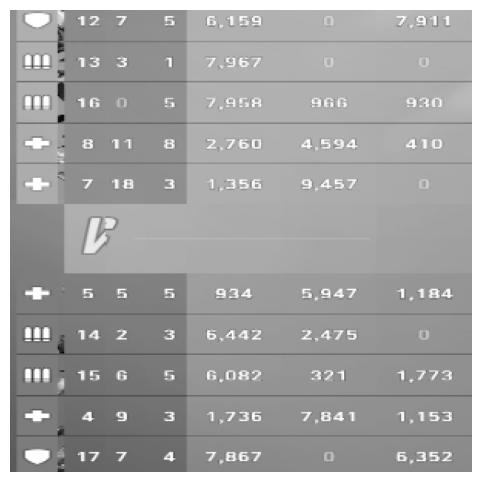

0.0 1.0 0.21052632 0.11290322 0.2173913 0.20583518 0.0 0.23063467 0.0 2.0 0.22807017 0.048387095 0.04347826 0.26625893 0.0 0.0 0.0 2.0 0.28070176 0.0 0.2173913 0.26595816 0.036564592 0.027112912 0.0 3.0 0.14035088 0.17741935 0.3478261 0.09223983 0.17389001 0.011953005 0.0 3.0 0.12280702 0.29032257 0.13043478 0.045317825 0.35796207 0.0 1.0 3.0 0.0877193 0.08064516 0.2173913 0.03121449 0.22510314 0.034517944 1.0 2.0 0.24561404 0.032258064 0.13043478 0.2152931 0.09368258 0.0 1.0 2.0 0.2631579 0.09677419 0.2173913 0.20326181 0.012150346 0.051689453 1.0 3.0 0.07017544 0.14516129 0.13043478 0.05801751 0.29679397 0.03361418 1.0 1.0 0.2982456 0.11290322 0.17391305 0.26291692 0.0 0.1851841


In [247]:
from pathlib import Path
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show

size = (300, 300)

# ==========================
# 이미지 전처리 함수
# ==========================

def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, size) / 255.0
    return resized, label


# ==========================
# Dataset 생성
# ==========================

image_paths = sorted(map(str, Path().rglob('*.png')))
data_count = len(df_array)

dataset = (
    Dataset.from_tensor_slices((image_paths, df_array))
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(data_count)
)

train_size = int(data_count * 0.9)
train_ds = dataset.take(train_size).batch(32).prefetch(AUTOTUNE)
val_ds = dataset.skip(train_size).batch(32).prefetch(AUTOTUNE)

# ==========================
# 샘플 시각화
# ==========================

for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [134]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import AdamW

clear_session()

# ==========================
# CNN 백본 모델 정의
# ==========================

input_tensor = Input(shape=size + (1,))

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# ==========================
# 다중 출력층 생성
# ==========================

unique_counts = df.nunique()
outputs = []
for i in range(10):
    outputs.append(Dense(1, 'sigmoid', name=f'T_{i}')(x))
    outputs.append(Dense(4, 'softmax', name=f'R_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'E_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'A_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'DE_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'DA_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'H_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'M_{i}')(x))
model = Model(inputs=input_tensor, outputs=outputs)

# ==========================
# 모델 컴파일
# ==========================

loss = {}
for i in range(10):
    loss[f'T_{i}'] = 'binary_crossentropy'
    loss[f'R_{i}'] = 'sparse_categorical_crossentropy'
    loss[f'E_{i}'] = 'mse'
    loss[f'A_{i}'] = 'mse'
    loss[f'DE_{i}'] = 'mse'
    loss[f'DA_{i}'] = 'mse'
    loss[f'H_{i}'] = 'mse'
    loss[f'M_{i}'] = 'mse'
metrics = {}
for i in range(10):
    metrics[f'T_{i}'] = 'accuracy'
    metrics[f'R_{i}'] = 'accuracy'
    metrics[f'E_{i}'] = 'mse'
    metrics[f'A_{i}'] = 'mse'
    metrics[f'DE_{i}'] = 'mse'
    metrics[f'DA_{i}'] = 'mse'
    metrics[f'H_{i}'] = 'mse'
    metrics[f'M_{i}'] = 'mse'
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=loss,
    metrics=metrics
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 300,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 300, 300,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 37,    │    294,912 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 18, 18,    │          0 │ re_lu_3[0][0]   

 Total params: 43,016,718 (164.10 MB)

 Trainable params: 43,015,758 (164.09 MB)

 Non-trainable params: 960 (3.75 KB)

In [135]:
from tensorflow.keras.callbacks import Callback, EarlyStopping


# ==========================
# 모델 학습
# ==========================

class AverageAccuracyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # logs에 accuracy가 여러개로 들어있다면 평균 계산
        acc_keys = [k for k in logs.keys() if 'accuracy' in k and 'val' not in k]
        val_acc_keys = [k for k in logs.keys() if 'val_accuracy' in k]

        if acc_keys:
            logs['accuracy'] = sum([logs[k] for k in acc_keys]) / len(acc_keys)
        if val_acc_keys:
            logs['val_accuracy'] = sum([logs[k] for k in val_acc_keys]) / len(val_acc_keys)

        # 원하는 정보만 출력
        def safe_format(value):
            return f'{value:.4f}' if value is not None else 'N/A'

        print(f'Epoch {epoch + 1}: '
              f'loss={safe_format(logs.get("loss"))}, '
              f'val_loss={safe_format(logs.get("val_loss"))}, '
              f'accuracy={safe_format(logs.get("accuracy"))}, '
              f'val_accuracy={safe_format(logs.get("val_accuracy"))}')


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(  # 검증 손실 기준으로 모니터링
    patience=8,  # patience 동안 개선 없으면 종료
    verbose=1,
    restore_best_weights=True  # 가장 성능 좋았던 가중치로 복원
)

# 학습
history = model.fit(
    train_ds,
    epochs=32,
    verbose=0,  # 기본 출력 끄기
    validation_data=val_ds,
    callbacks=[AverageAccuracyLogger(), early_stop]
)

Epoch 1: loss=688.5532, val_loss=24.5068, accuracy=0.3243, val_accuracy=N/A
Epoch 2: loss=263.4697, val_loss=24.5281, accuracy=0.4181, val_accuracy=N/A
Epoch 3: loss=48.3456, val_loss=24.6157, accuracy=0.3403, val_accuracy=N/A
Epoch 4: loss=24.6206, val_loss=24.6011, accuracy=0.6944, val_accuracy=N/A
Epoch 5: loss=24.9677, val_loss=24.6270, accuracy=0.7785, val_accuracy=N/A
Epoch 6: loss=24.6865, val_loss=24.6654, accuracy=0.7444, val_accuracy=N/A
Epoch 7: loss=24.8361, val_loss=24.6624, accuracy=0.7521, val_accuracy=N/A
Epoch 8: loss=24.3663, val_loss=24.6187, accuracy=0.8597, val_accuracy=N/A
Epoch 9: loss=24.9836, val_loss=24.6309, accuracy=0.7257, val_accuracy=N/A
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


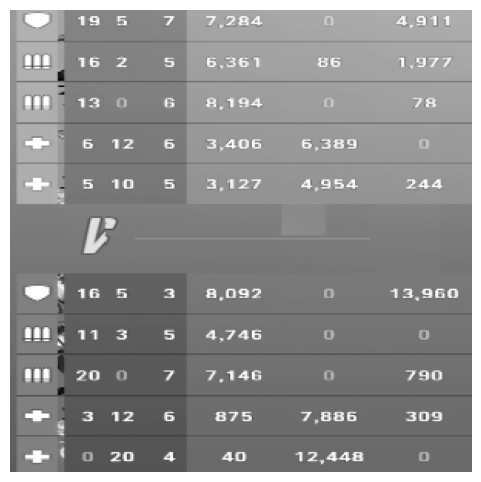

0.0 1.0 0.33333334 0.08064516 0.3043478 0.24343292 0.0 0.14317366 0.0 2.0 0.28070176 0.032258064 0.2173913 0.21258606 0.003255233 0.057636805 0.0 2.0 0.22807017 0.0 0.26086956 0.27384534 0.0 0.002273986 0.0 3.0 0.10526316 0.19354838 0.26086956 0.11382929 0.24183352 0.0 0.0 3.0 0.0877193 0.16129032 0.2173913 0.10450505 0.18751656 0.0071134954 1.0 1.0 0.28070176 0.08064516 0.13043478 0.27043647 0.0 0.40698522 1.0 2.0 0.19298245 0.048387095 0.2173913 0.15861239 0.0 0.0 1.0 2.0 0.3508772 0.0 0.3043478 0.23882094 0.0 0.023031399 1.0 3.0 0.05263158 0.19354838 0.26086956 0.029242698 0.2984973 0.009008484 1.0 3.0 0.0 0.32258064 0.17391305 0.001336809 0.47117606 0.0


In [323]:
from numpy import array

for x_batch, y_batch in val_ds.take(1):
    x_sample = x_batch[0:1]
    y_sample = tuple(y[0] for y in y_batch)
    y_pred = model.predict(x_sample)
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [327]:
y_sample_ = (array(y_sample).reshape(-1, 8) * ([[1, 1] + list(numeric_max)] * 10)).round().astype(int)
y_sample_

array([[    0,     1,    19,     5,     7,  7284,     0,  4911],
       [    0,     2,    16,     2,     5,  6361,    86,  1977],
       [    0,     2,    13,     0,     6,  8194,     0,    78],
       [    0,     3,     6,    12,     6,  3406,  6389,     0],
       [    0,     3,     5,    10,     5,  3127,  4954,   244],
       [    1,     1,    16,     5,     3,  8092,     0, 13960],
       [    1,     2,    11,     3,     5,  4746,     0,     0],
       [    1,     2,    20,     0,     7,  7146,     0,   790],
       [    1,     3,     3,    12,     6,   875,  7886,   309],
       [    1,     3,     0,    20,     4,    40, 12448,     0]])

In [328]:
print(f'T R  E  A DE  DA    H    M')
for i in range(10):
    print(f'{int(y_pred[0 + i * 8][0][0] >= 0.5):1d}', end=' ')
    print(f'{y_pred[1 + i * 8][0].argmax():1d}', end=' ')
    print(f'{int((y_pred[2 + i * 8][0][0] * numeric_max.iloc[0]).round()):2d}', end=' ')
    print(f'{int((y_pred[3 + i * 8][0][0] * numeric_max.iloc[1]).round()):2d}', end=' ')
    print(f'{int((y_pred[4 + i * 8][0][0] * numeric_max.iloc[2]).round()):1d}', end=' ')
    print(f'{int((y_pred[5 + i * 8][0][0] * numeric_max.iloc[3]).round()):4d}', end=' ')
    print(f'{int((y_pred[6 + i * 8][0][0] * numeric_max.iloc[4]).round()):4d}', end=' ')
    print(f'{int((y_pred[7 + i * 8][0][0] * numeric_max.iloc[5]).round()):4d}', end=' ')
    print()

T R  E  A DE  DA    H    M
0 2  2  2 0   88  186  -36 
0 2  0 -1 -1 -572 -960  270 
1 2  0 -1 0 -115  159 -570 
1 0  0 -2 0  374 -554  803 
0 0  0  1 0 -474 -145 -566 
1 1  0  1 0  117  301  -74 
0 3  0 -1 0  100  357  603 
1 2  0  0 0  356 -580 -203 
1 0 -2  0 0 -539  -24 -185 
1 0  0  1 0  353 -160 -100 
